### Variational Inference for Probabilistic PCA

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits

from observations import iris
DATA_DIR = './data'


plt.style.use("ggplot")
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
dataset = load_digits()
# dataset = load_iris()
x_train, y_class = dataset.data, dataset.target
x_train = StandardScaler().fit_transform(x_train)
x_train = x_train.T

In [4]:
x_train, y_train, metadata = iris(DATA_DIR)

# standardize data
# x_mean = np.mean(x_train, axis=0)
# x_std = np.std(x_train, axis=0)
# x_train = (x_train - x_mean) / x_std

x_train = x_train.T
print(x_train.shape, y_train.shape)
print(metadata)

y_label = np.unique(y_train)
y_dict = dict((label, i) for i, label in enumerate(y_label))
y_class = list(map(lambda label: y_dict[label], y_train))

(4, 150) (150,)
{'columns': ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']}


In [5]:
data_dim, num_datapoints = x_train.shape
latent_dim = 2
stddv_datapoints = 1e-5
print(data_dim, num_datapoints)

4 150


#### PPCA model components:
+ Latent variable $\mathbf{z}_n \in \mathbb{R}^{K}$:  $\mathbf{z}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
+ Model parameters $\mathbf{W} \in \mathbb{R}^{DxK}$, which is the principal components
    $\mathbf{W} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
+ Modeled data $\mathbf{x}_n \in \mathbb{R}^{D}$ (conditioned on the latent vars): $\mathbf{x}_n | \mathbf{z}_n \sim  \mathcal{N}(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I})$

In [6]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    z = ed.Normal(
        loc=tf.zeros([latent_dim, num_datapoints]),
        scale=tf.ones([latent_dim, num_datapoints]),
        name='z'
    )
    
    w = ed.Normal(
        loc=tf.zeros([data_dim, latent_dim]),
        scale=tf.ones([data_dim, latent_dim]),
        name='w'
    )
    
    x = ed.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
        name='x'
    )
    
    return x, (w, z)

log_joint_ppca_model = ed.make_log_joint_fn(ppca_model)

### Variational Inference:
Learn the distribution of the parameters `W` and `Z` from the observed data `X` using VI method.
The goal is to approximate the posterior prob. dist. $p(W, Z | X)$ but it is not possible.

VI method offers a mechanism to approximate the posterior prob. dist. by using a family of variational distribution $q(W, Z; \lambda)$.

The problem is thus:
$$
    \lambda = argmin_{\lambda} KL(q({W, Z; \lambda}) || p(W, Z | X))
$$

According to [this guide](http://edwardlib.org/tutorials/klqp), this problem is equivalent to:
$$
    \lambda = argmin_{\lambda} \mathbb{E}_{q({W, Z; \lambda})}[\log p(W, Z, X) - \log q({W, Z; \lambda})]
$$

The first term $\mathbb{E}_{q({W, Z; \lambda})}[\log p(W, Z, X)]$ is called **energy**,
the second term $ - \mathbb{E}_{q({W, Z; \lambda})}[\log q({W, Z; \lambda})]$ is **entropy** of $q$.

The first term: we have had `log_joint_ppca_model` defined above.
For the second term, we need to define a _variational model_ $q$.

$q$ constaints two random vars, so for specifing $q$, we need to find out the characteristiques of each random var (mean and variance for each $W$ and $Z$).

In [7]:
def train_vi(num_epochs=1000, fixed_learning_rate=0.1,stddv_datapoints=1e-6):
    # because we've run the computational graph of TF once,
    # before continuing to run the TF code, we MUST reset the computational graph
    tf.reset_default_graph()

    # for the first term: define an energy function
    def energy_func(qw, qz):
        return log_joint_ppca_model(
            data_dim=data_dim, latent_dim=latent_dim,
            num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
            x=x_train, w=qw, z=qz
        )

    # for the second term:
    # first, define the variational model of two variable W and Z
    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name='qw')
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name='qz')
        return qw, qz

    log_joint_variational_model = ed.make_log_joint_fn(variational_model)

    # then, define the variables for W and Z (note to specify the default values for them)
    qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32))

    # finally, define the entropy function
    def entropy_func(qw, qz):
        return - log_joint_variational_model(
            qw_mean=qw_mean, qw_stddv=qw_stddv, qz_mean=qz_mean, qz_stddv=qz_stddv,
            qw=qw, qz=qz
        )

    # once we have the `variational_model`
    # use this model to specify the variational variables `qw` and `qz`
    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)

    # define how to calculate the energy and entropy
    energy = energy_func(qw, qz)
    entropy = entropy_func(qw, qz)

    # define an ELBO objective function
    elbo = energy + entropy

    # define how to maximize the ELBO (or minimize -elbo)
    lr = tf.placeholder(tf.float32, shape=[])
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_process = optimizer.minimize(-elbo)

    init_process = tf.global_variables_initializer()
    losses = []

    with tf.Session() as sess:
        # first, make sure to init all varaibles
        sess.run(init_process)

        # then run the training process
        for i in range(1, num_epochs):
            lr_val = fixed_learning_rate # + np.log(i) * 1e-2
            sess.run(train_process, feed_dict={lr: lr_val})

            # log the value of ELBO objective function
            if i % 5 == 0:
                losses.append(sess.run([elbo]))

        print('final learning rate: ', lr_val)
        
        # after finishing the training, make sure to collect the target parameters
        w_mean, w_std, z_mean, z_std = sess.run([qw_mean, qw_stddv, qz_mean, qz_stddv])
        
    return losses, w_mean, w_std, z_mean, z_std

final learning rate:  0.5


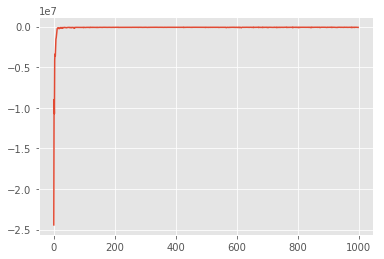

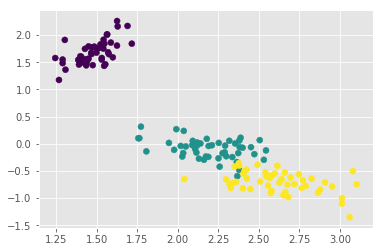

In [8]:
losses, w_mean, w_std, z_mean, z_std = train_vi(
    num_epochs=5000, fixed_learning_rate=.5,stddv_datapoints=0.01)
plt.plot(range(len(losses)), losses)
plt.show()
plt.scatter(z_mean[0, :], z_mean[1, :], c=y_class)
plt.show()